# Basin Scale GW Modeling

### Scenario Analysis 

GroMore is proposing to start a new agricultural effort in the basin. Their proposal is included in the base model as the rectangular irrigated area with the elevated ET and the shallow pumping well. They are resistant to changing this plan (location of the farm, crop, location of pumping well, etc) because they have agreements with the current landowner and have done a market analysis based on the proposed pumping and the projected value of the crop. 


## Model Description 
Basin box model for scenario analysis 

#### Dimensions: 
- 50 x 50 x 3
- dx = dy = 1000 m
- dz =   

#### Topography
- Land surface elevation (base_model_elevs.csv file)
- Middle & bottom layers are horizontal.

#### Subsurface Properties: 
- Top & Bot layers 
          Kx = Ky = Kz = 10 m/day 
 
- Middle layer
          Kx = Ky = 10 m/d, 
          Kz = 10 m/d     1st 20 left most columns
          Kz = 1e-04      in the rest of the layer
 
- see NO FLOW corners in (NoFlow_Boundaries excel file)
- Porosity = 0.10
- Specific yield = 0.10
- Storage coefficient = 0.0001  

#### Boundary Conditions: 
   - Right boundary is a constant head of 70 m 
   - All other boundaries are no flow
   - Note NO FLOW boundaries in the domain (see map on excel file: NoFlow_Boundaries)
   - Recharge (uniform) occurs in the 1st 15 left most columns throughout the domain. R = 4E-5 m/d 
   - ET occurs in the right half of the model domain. ET = 1e-5 m/d
   - ET_rip occurse across the riparian area in the domain (row 23 thru row 29). ET_rip = 5e-5 m/d
 
#### Wells: 
 - Water Supply well (bottom layer)
       located at (38000,21000 ) or (row 21 & col 38)
       pumping rate = 1500 m^3/d
 

 
 - Monitoring wells (top layer)
      - MW1 located at (25000, 25000)
      - MW2 located at (12500, 12500)
       
#### Irrigation Field     
   . Located at (14000, 12000) or (row 12 & col 14)
     
   . Pumping at a rate of (crop water demand)+ 0.20(excess irrig) + 0.30 (irrig inefficiency) m^3/d 
       - for wheat,Q = 3000 m^3/d
       - for Pistachio,Q = 4500 m^3/d
       - for Cotton,Q = 6000 m^3/d
      
      * 1/8th of the area will be irrigated at any time (the field area is multiplied by 0.125).
      - located at (18000,20000) and (20000,22000) or (row 21 & 22 and col 19 & 20)
      - 2000 m x 2000 m area.
      
#### Recharge  (or the crop water use)       
       *  Wheat = 0.004m/d / 0.0001m/d
       *  Pistachios= 0.006m/d / 0.00015m/d
       *  Cotton: 0.008 m/d / 0.0002 m/d

### stream
      - runs from left to right domain boundary on row 26  
      - stream width, & thickness = 1 m
      - K of river sediment = 1000 m/d
      - stream bottom Elev = Zbot (of river grid cell) - 1 
      - stream stage = 0.5 m
    


## Scenario 3: Post development with seasonality 

Build the pre-development model with seasonality and extend the run time to 100 years PLUS your burn in time. This represents the 100 years that the town has been pumping to date. There was no pumping during the pre-development period. The town's water demand has increased exponentially, with the pumping rate changed every 10 years following the equation: Q = 1.5 * t^1.5, for Q in m3/day and t in years. To avoid confusion, the pumping rate is zero for for the burn-in time (I'll assume 25 years, here). Then, on April 1 of year 25, the pumping increases to 47 m3/day. On April 1 of year 35 it increases to 134 m3/day. Then, on a 10 year schedule, it continues to: 246; 379; 530; 697; 878; 1073; and 1281 m3/day. This model defines the system at the current time - remember, the town has been pumping for 100 years already. 

## 1. Setup the environment

In [1]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#print full output
np.set_printoptions(threshold=np.inf)

#jupyter specific--included to show plots in notebook
%matplotlib inline 

 #Delete Packages
# dir = "/Users/amanda_triplett/Documents/Courses/groundwater_Modeling/GroMore_Project/amanda/scenario2"
# files = os.listdir(dir)
# ext=['.dis','.bas','.lpf','.oc','.pcg','.wel','.hds','.cbc','.riv','.list','.nam','.evt',
#      '.rch','.mpbas','.mpend','.mplst','.mpnam','.mppth','.mpsim','.log','.timeseries',
#      '.lis','.chd','.ddn','.sloc']
# for file in files:
#     for i in range(0,len(ext)):
#         if file.endswith(ext[i]):
#             os.remove(os.path.join(dir,file))

flopy is installed in C:\Users\HG\Anaconda3\lib\site-packages\flopy


In [2]:
#print(len(ext))


## 2. Input variables 

In [3]:
## Discritization
nrow = 50 
ncol = 50 
nlay = 3  
#laytyp = 1

dx= 1000      
dy= 1000     

Lx = ncol*dx  #length of domain in x
Ly = nrow*dy #length of domain in y

#subsurface property
n = 0.1        #porosity
Ss = 1e-4      #storage coefficient
Sy = 0.1        # specific yield
uncnf = 1       #0=confined, >0 = unconfined

ztop = np.genfromtxt('base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)
ztop[0,0] = 124.                                           # insert missing initial value (not sure why didn't import)
#print(type(ztop))
#print(ztop.shape)
#print(ztop[0,:])
zbot = 0.     #bottom elevation

#dz = (ztop - zbot) / nlay    #cell height in z direction

# constant head boundary
h_right = 70



### Layers

In [4]:
## Subsurface properties
K_horiz = 10.    #horizontal hydraulic conductivity 
Kz_1 = 10      # vert hyd cond for left most 20 columns in layer 2. And, entire top & bot layers
Kz_2 = 1e-4  #vert hyd cond for the rest of columns in layer 2


#Layering
Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz                 # assign the original value to the entire array

Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = Kz_1                   # assign Kz to all layers
Kz[1,:,20:48] = Kz_2                 #Replace the Kz in the middle layer with the lower Kz value

#Layer elevations
bot_elev = 0.  # bottom elevation of lowest layer 
mid_elev = 40. #bottom elevation of middle layer  
top_elev = 45. # bottom elevation of top layer  

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[2,:,:] = bot_elev                 
botm[1,:,:] = mid_elev                          
botm[0,:,:] = top_elev                 



## Timing Variables

In [5]:
  #two stress periods : (April - Sept) & (Oct - March)
sp_peryr = 2   # periods for seasonality (two stress periods per year)
sp1_len = 180   # Length of stress period 1 in days
sp2_len = 180  # Length of stress period 2 in days

sim_years = 125   #number of years for transient simulation 
nper = int(sp_peryr*sim_years + 1)  # total number of stress periods the +1 is for the steady state start

#setup the steady state array
steady = np.ones(nper, dtype=bool)*False     # steady-state or transient flag for each stress period (boolean array)
steady[0] = True    # initial stress period is steady-state

#make an array of period lengths
perlen=np.tile([sp1_len, sp2_len],sim_years)
perlen=np.append(10,perlen) #add a period of length 10 at the start for the ss simulation
#print("Period lengths", perlen)

#make an nstp array for the # of time steps to solve within each period (daily in this case) 
#so we can repeat the perlen array

nstp = perlen/5           # ModFlow solver attain solution every x days
nstp[0]=1         #for the steady state solution we just want one output
nstp = nstp.astype(int)  #avoids TypeError:'numpy.float64' object cannot be interpreted as an integer
#print("Number of Steps", nstp)

#recharge_zone =recharge_zone + rech1
# R = {}                          # create empty dictionary for recharge fluxes
# for p in range(0,nper):         # loop over stress periods, skipping initial steady state defined above
#     R[p]=recharge_zone
#     #print(R[p])
print(nstp)

[ 1 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36 36 36 36 36 36]


## Hydrologic stresses on basin

In [6]:
## Recharge
rech_zone = np.zeros((1,nrow,ncol))
rech = 4e-5  #m/d
rechxy=[(0,0),(0,36000)]  #recharge zone

rech_rows_forced = (1.0, 49.0) #rech zone forced for leftmost 15 cols
rech_cols_forced = (1.0, 15.0)

rech_zone[0,int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech
#print("recharge location forced(col, row)", rech_cols_forced,rech_rows_forced)

# #rech_rows_forced = (1.0, 49.0) #rech zone forced for leftmost 15 cols
# #rech_cols_forced = (1.0, 15.0)
# rech_llxy = [0,0]  # lower left xy coords
# rech_urxy = [15000,50000] # upper right xy coords

ET = 1e-5     #m/day
ET_locxy=[[24000,0], [0, 0]] #lower left and upper right corners of ET in xy coordinate

ET_rip= 5e-5      #riparian zone
rip_locxy= [[0,21000],[23000,0]]

extinction_depth = 10 #m
#print(ET_locxy)
#print(rip_loc)

ET_zone = np.zeros((1,nrow,ncol))  
ET_rows_forced=(1.0, 49.0) #me forcing the et_rows to be 0-50
ET_cols_forced = (26.0, 49.0)

# define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]),int(ET_cols_forced[0]):int(ET_cols_forced[1])] = ET 

#rip_zone = np.zeros((1,nrow,ncol)) 
rip_rows_forced = (21.0, 28.0)  #forced riparian area
rip_cols_forced = (1.0, 49.0)

# ET_rip_llxy = [0,23000] #lower left corner xy for riparian strip
# ET_rip_urxy = [50000,29000] #upper left corner for riparian strip

    # define an array of zeroes the size of the model grid
ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]),int(rip_cols_forced[0]):int(rip_cols_forced[1])] = ET_rip 
#print("Riparian location(col, row)", rip_cols,rip_rows)

h_right = 70  

## Timing
# nper = 1 #number of stress periods 
# steady = [True] #list noting the stress period type

 # pumping rate in the Aquaseca community water supply well 
 # pumping increase every 10 yr starting yr 25 (Burn in time): Q = 1.5* t^1.5

Q = [0, -47, -134, -246, -379, -530, -697, -878,-1073,-1281,-1500]  # m^3/day   

well_1_xy= [38000, 21000] # xy location of supply well 
well_1_row = np.floor((nrow-1)-(well_1_xy[1]/dy)) #convert the y location to a row (python row)
well_1_col=np.floor(well_1_xy[0]/dx-1) #convert the x location to a column
town_wel = [2,well_1_row,well_1_col] # Well loc (layer, row, column) # pumping is going to vary with time
#print("Cwell cell",well_1_loc)

well_2_xy= [14000, 12000] # xy location of irrigation well 
well_2_row = np.floor((nrow-1)-(well_2_xy[1]/dy)) #convert the y location to a row 
well_2_col=np.floor(well_2_xy[0]/dx-1) #convert the x location to a column
irrg_wel = [0,well_2_row,well_2_col,0] #Well loc (layer, row, column)

print("irrg_wel cell", irrg_wel)


MW1_xy =[25000, 25000] # xy location of monitoring well 1 
# MW1_row = np.floor((nrow-1)-(MW1_xy[1]/dy))  
# MW1_col=np.floor(MW1_xy[0]/dx-1) 
# MW1_loc = [0,MW1_row,MW1_col,0] 
MW1 = [0,25,25,0] # forced
#print("MW1 cell", MW1_loc)

MW2_xy = [12500, 12500] # xy location of smonitoring well 2 
MW2_row = np.floor((nrow-1)-(MW2_xy[1]/dy)) 
MW2_col=np.floor(MW2_xy[0]/dx-1) 
#MW2 = [0,MW2_row,MW2_col,0] 
MW2 = [0,36,11,0]
#print ("MW2 cell", MW2)

# pumping [layer, row, col,Q]
P0 = [2,well_1_row,well_1_col,Q[0]]    # 0- 25] 25 yrs is the Burn in time. Q = 0 predvpt pumping at town well = 0 m3/day        
P10 = [2,well_1_row,well_1_col,Q[1]]   # (25 - 35],            Q =  47 pumping begins with 47 m3/day     
P20 = [2,well_1_row,well_1_col,Q[2]]   # (35 -  45]
P30 = [2,well_1_row,well_1_col,Q[3]]   # (45 -  55]
P40 = [2,well_1_row,well_1_col,Q[4]]   # (55 -  65]
P50 = [2,well_1_row,well_1_col,Q[5]]   # (65 -  75]
P60 = [2,well_1_row,well_1_col,Q[6]]   # (75 -  85]
P70 = [2,well_1_row,well_1_col,Q[7]]   # (85 -  95]
P80 = [2,well_1_row,well_1_col,Q[8]]   # (95 - 105] 
P90 = [2,well_1_row,well_1_col,Q[9]]   # (105 - 115]
P100 =[2,well_1_row,well_1_col,Q[10]]  # (115 - 125]

#Set up the wel data for stress periods 
wel_spd = {}  
# for p in range(0,51):
#     town_wel.append(pumping_predevel)
#     wel_spd[p]=[town_wel, irrg_wel, MW1, MW2] 
for p in range(0,nper): #nper = 251
    if p <= 51: 
        wel_spd[p]=[P0, irrg_wel, MW1, MW2]     
    elif p > 51 and p <= 71:
        wel_spd[p]=[P10, irrg_wel, MW1, MW2]
    elif p > 71 and p <= 91:
        wel_spd[p]=[P20, irrg_wel, MW1, MW2]
    elif p > 91 and p <= 111:
        wel_spd[p]=[P30, irrg_wel, MW1, MW2]
    elif p > 111 and p <= 131:
        wel_spd[p]=[P40, irrg_wel, MW1, MW2]
    elif p > 131 and p <= 151:
        wel_spd[p]=[P50, irrg_wel, MW1, MW2]
    elif p > 151 and p <= 171:
        wel_spd[p]=[P60, irrg_wel, MW1, MW2]
    elif p > 171 and p <= 191:
        wel_spd[p]=[P70, irrg_wel, MW1, MW2]
    elif p > 191 and p <= 211:
        wel_spd[p]=[P80,irrg_wel,MW1,MW2]
    elif p > 211 and p <= 231:
        wel_spd[p]= [P90,irrg_wel,MW1,MW2]
    else:
        wel_spd[p]= [P100,irrg_wel,MW1,MW2]



        
print('Q at sp 250 =', wel_spd[250])

irrg_wel cell [0, 37.0, 13.0, 0]
Q at sp 250 = [[2, 28.0, 37.0, -1500], [0, 37.0, 13.0, 0], [0, 25, 25, 0], [0, 36, 11, 0]]


In [7]:
# set river
riv_row = 24
riv_sp =[]
riv_width = 1
k_sedt = 1000
sedt_thick = 1

cond = (k_sedt * riv_width * dx) / sedt_thick

r_stage = 0.5
r_bott = ztop [riv_row,:]
#river stress preriod data (lay,row,col, stage, cond,rbot)
for i in range (1,ncol):
    riv_sp.append([0,riv_row, i, r_bott[i]-1+sedt_thick+r_stage, cond, r_bott[i]-2])
#print(riv_spd)
#create dictionary of stress period data
riv_spd = {0: riv_sp}
print(riv_row)

24


  ### set ET seasonality

In [8]:

# Estimate the steady_state ET for all ET_zones in model
ET_ss = (6/50)*ET_rip + (25/50)*ET  # weighted average of the two ET zones in domain. weighted by the cols they cover
#print ('ss_ET', ET_ss)               

#Setup alternating ET values
#ET_zone has the seasonal ET values
                      
# ET = {} #set up an ET dictionary, where each key is a stress period num 0-50
# ET_zone2 = ET_zone * 0 
# for p in range(0,nper):    #loop over stress periods, odds are 0 ET, evens are reg ET
#     if p == 0:
#         ET[p] = ET_zone
#     elif int(p % 2) != 0:
#         ET[p]=ET_zone2
#         #print(p)
#     else: 
#         ET[p] = ET_zone
# print(ET[0])

ET_zone2 = ET_zone * 0 
ET_val=np.tile([ET_zone,ET_zone2],sim_years)
ET_val=np.append(ET_ss,ET_val)
#print(ET_val)

ET = {} #set up an ET dictionary, where each key is a stress period num 0-50
ET_zone2 = ET_zone * 0 
for p in range(0,nper):    #loop over stress periods, odds are 0 ET, evens are reg ET
    if p == 0:
        ET[p] = ET_zone 
    elif int(p % 2) != 0:
        ET[p]=ET_zone2
        #print(p)
    else: 
        ET[p] = ET_zone
#     #print(np.sum(ET[p]))
#print(ET[0])    

# Boundry Condition

In [9]:
# initial heads 
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  
H_init[:, :, :] = h_right  #initialize the entire domain to h_right value
H_init[:, :, 49] = h_right    #replace first (right) col with desired head value

#Define cell activity (IBOUND)
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head
ibound[:,:,49] = -1          #constant head
                                         

ibound[:,:,0] = 0    # left boundary: no flow       
ibound[:,:,49] = -1  # right boundary: constant head 
ibound[:,0,:49] = 0    # bottom boundary: no flow
ibound[:,49,:49] = 0   # top boundary: no flow

# All layers - bottom left corner
ibound[:,1,:5]=0     
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

#All layers - top left corner
ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

# mid + bot layers - bottom left corner
ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,:2]=0

# mid + bot layers - top left corner
ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,:2]=0

# bottom layer - bottom left corner
ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,:2]=0

#layer 3 - top left corner
ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,:2]=0

np.set_printoptions(threshold=np.inf)

#print(ibound[1])
# np.savetxt("write0.csv", ibound[0], delimiter=",")


## 3. Setup and run Transient MODFLOW  

In [10]:
#Initialize the model
modelname = "scena3"
moddir="C:/Users/HG/Documents/AHWR_582/GM_Scenarios/scenar3/mf2005.exe"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

 
#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady,perlen=perlen, nstp = nstp)

#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right    #initialize the entire domain to the right head value
#H_init[:, :, 0] = h_left    #replace first (left) col with desired head value

bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

#Recharge 
rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, ipakcb=53)     

#ET:
evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET, exdp=extinction_depth, ipakcb=53) 

#Setup flopy CHD object
#chd = flopy.modflow.ModflowChd(model=m, stress_period_data=chd_spd)

#attach river package
riv = flopy.modflow.ModflowRiv(model=m,stress_period_data = riv_spd, ipakcb=53)

# #Well
# well_1 = [i for i in well_1_loc] + [pumping1]
# print("Well 1 [layer, row, column, flux]: \n", well_1)
# well_2 = [i for i in well_2_loc] + [pumping2]
# print("Well 2 [layer, row, column, flux]: \n", well_2)
# MW1 = [i for i in MW1_loc] + [0] 
# print("MW_1 [layer, row, column, flux]: \n", MW1)
# MW2 = [i for i in MW2_loc] + [0]
# print("MW_2 [layer, row, column, flux]: \n", MW2)

#wel_spd = {0: [well_1_loc, well_2_loc, MW1_loc, MW2_loc]}

wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)

## Output control - OC 

spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 

oc_spd = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        #print(kstp)
        oc_spd[(kper, kstp)] = ['save head','save drawdown','save budget','print head','print budget']
#print(np.shape(oc_spd))


oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m, mxiter=1500, iter1=500, relax=0.97, damp=0.9)

#write the inputs
m.write_input()    

m.evt.check()
m.oc.check()
m.lpf.check()
m.pcg.check()
m.riv.check()
m.rch.check()
m.dis.check()
#m.chd.check()

#Run the model 
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')


check method not implemented for EVT Package.

OC PACKAGE DATA VALIDATION:
  No errors or warnings encountered.


LPF PACKAGE DATA VALIDATION:
  1 Warning:
    STORAGECOEFFICIENT option is activated, storage values are read storage coefficients

  Checks that passed:
    zero or negative horizontal hydraulic conductivity values
    zero or negative vertical hydraulic conductivity values
    negative horizontal anisotropy values
    horizontal hydraulic conductivity values below checker threshold of 1e-11
    horizontal hydraulic conductivity values above checker threshold of 100000.0
    vertical hydraulic conductivity values below checker threshold of 1e-11
    vertical hydraulic conductivity values above checker threshold of 100000.0
    zero or negative specific storage values
    specific storage values below checker threshold of 1e-06
    specific storage values above checker threshold of 0.01
    zero or negative specific yield values
    specific yield values below checker thres

 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    22    Ground-Wa

 Solving:  Stress period:     7    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    20    Ground-Wa

 Solving:  Stress period:    10    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    19    Ground-Wa

 Solving:  Stress period:    13    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    19    Ground-Wa

 Solving:  Stress period:    16    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    19    Ground-Wa

 Solving:  Stress period:    19    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    18    Ground-Wa

 Solving:  Stress period:    22    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    15    Ground-Wa

 Solving:  Stress period:    25    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    14    Ground-Wa

 Solving:  Stress period:    28    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    14    Ground-Wa

 Solving:  Stress period:    30    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    11    Ground-Wa

 Solving:  Stress period:    33    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:     8    Ground-Wa

 Solving:  Stress period:    36    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    10    Ground-Wa

 Solving:  Stress period:    39    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    11    Ground-Wa

 Solving:  Stress period:    43    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    13    Ground-Wa

 Solving:  Stress period:    46    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    13    Ground-Wa

 Solving:  Stress period:    48    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    12    Ground-Wa

 Solving:  Stress period:    52    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    13    Ground-Wa

 Solving:  Stress period:    55    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    13    Ground-Wa

 Solving:  Stress period:    58    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    13    Ground-Wa

 Solving:  Stress period:    61    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    14    Ground-Wa

 Solving:  Stress period:    64    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    13    Ground-Wa

 Solving:  Stress period:    67    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    13    Ground-Wa

 Solving:  Stress period:    69    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    10    Ground-Wa

 Solving:  Stress period:    72    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:     9    Ground-Wa

 Solving:  Stress period:    75    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:     7    Ground-Wa

 Solving:  Stress period:    78    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:     9    Ground-Wa

 Solving:  Stress period:    81    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    11    Ground-Wa

 Solving:  Stress period:    84    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    10    Ground-Wa

 Solving:  Stress period:    87    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    11    Ground-Wa

 Solving:  Stress period:    90    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    12    Ground-Wa

 Solving:  Stress period:    94    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    13    Ground-Wa

 Solving:  Stress period:    96    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    10    Ground-Wa

 Solving:  Stress period:    99    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    11    Ground-Wa

 Solving:  Stress period:   102    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    10    Ground-Wa

 Solving:  Stress period:   105    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     9    Ground-Wa

 Solving:  Stress period:   108    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:     6    Ground-Wa

 Solving:  Stress period:   111    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     3    Ground-Wa

 Solving:  Stress period:   114    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     4    Ground-Wa

 Solving:  Stress period:   117    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     4    Ground-Wa

 Solving:  Stress period:   120    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:     2    Ground-Wa

 Solving:  Stress period:   123    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     3    Ground-Wa

 Solving:  Stress period:   126    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     4    Ground-Wa

 Solving:  Stress period:   129    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:     5    Ground-Wa

 Solving:  Stress period:   132    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:     4    Ground-Wa

 Solving:  Stress period:   135    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     5    Ground-Wa

 Solving:  Stress period:   138    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:     6    Ground-Wa

 Solving:  Stress period:   141    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     5    Ground-Wa

 Solving:  Stress period:   144    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     6    Ground-Wa

 Solving:  Stress period:   147    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:     8    Ground-Wa

 Solving:  Stress period:   150    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     7    Ground-Wa

 Solving:  Stress period:   153    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     7    Ground-Wa

 Solving:  Stress period:   156    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:     8    Ground-Wa

 Solving:  Stress period:   159    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     9    Ground-Wa

 Solving:  Stress period:   162    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    11    Ground-Wa

 Solving:  Stress period:   165    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    11    Ground-Wa

 Solving:  Stress period:   168    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    11    Ground-Wa

 Solving:  Stress period:   171    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    11    Ground-Wa

 Solving:  Stress period:   174    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    10    Ground-Wa

 Solving:  Stress period:   177    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     8    Ground-Wa

 Solving:  Stress period:   180    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:     9    Ground-Wa

 Solving:  Stress period:   183    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    12    Ground-Wa

 Solving:  Stress period:   187    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    14    Ground-Wa

 Solving:  Stress period:   190    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    14    Ground-Wa

 Solving:  Stress period:   192    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    12    Ground-Wa

 Solving:  Stress period:   196    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    14    Ground-Wa

 Solving:  Stress period:   198    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    11    Ground-Wa

 Solving:  Stress period:   201    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:    12    Ground-Wa

 Solving:  Stress period:   204    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   204    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   204    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:    10    Ground-Wa

 Solving:  Stress period:   207    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:    12    Ground-Wa

 Solving:  Stress period:   210    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:    10    Ground-Wa

 Solving:  Stress period:   213    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:    10    Ground-Wa

 Solving:  Stress period:   216    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:    10    Ground-Wa

 Solving:  Stress period:   219    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:    11    Ground-Wa

 Solving:  Stress period:   222    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   222    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:    11    Ground-Wa

 Solving:  Stress period:   226    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:    13    Ground-Wa

 Solving:  Stress period:   228    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:    12    Ground-Wa

 Solving:  Stress period:   232    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:    14    Ground-Wa

 Solving:  Stress period:   235    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:    15    Ground-Wa

 Solving:  Stress period:   238    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:    14    Ground-Wa

 Solving:  Stress period:   241    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:    15    Ground-Wa

 Solving:  Stress period:   244    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:    14    Ground-Wa

 Solving:  Stress period:   247    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:    16    Ground-Wa

 Solving:  Stress period:   250    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:    13    Ground-Wa


# 4. Plot domain boundary

### Plan view 

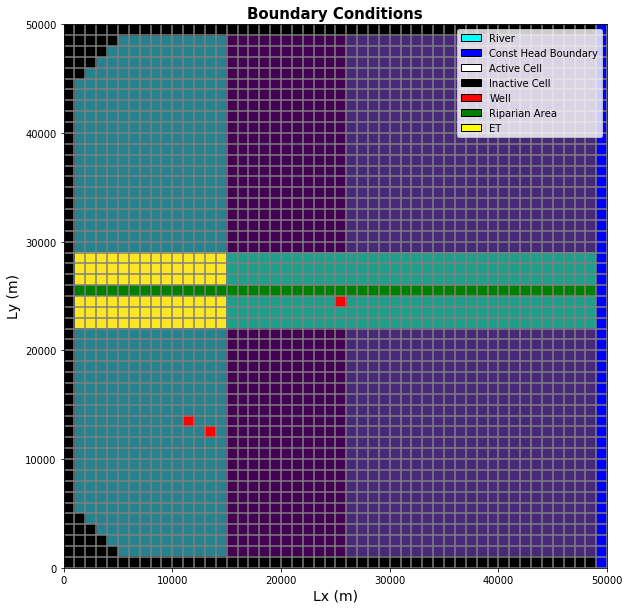

In [17]:
#CHECK BOUNDARY CONDITIONS
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
zones = ET_zone + rech_zone
quadmesh = modelmap.plot_array(zones)
#recharge = modelmap.plot_array((rech_zone), color = 'orange')
#ET = modelmap.plot_array(ET_zone)
riv_plot = modelmap.plot_bc(ftype='RIV')
wel_plot = modelmap.plot_bc(ftype='WEL')
quadmesh = modelmap.plot_ibound()

#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Boundary Conditions', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='cyan',label='River',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                   mp.patches.Patch(color='Red',label='Well',ec='black'),
                   mp.patches.Patch(color='green',label='Riparian Area',ec='black'),
                   mp.patches.Patch(color='Yellow',label='ET',ec='black')],)

### Cross section of the layered model
For more examples of cross section plotting check out this notebook: https://github.com/modflowpy/flopy/blob/develop/examples/Notebooks/flopy3.3_PlotCrossSection.ipynb 

C:\Users\HG\Anaconda3\lib\site-packages\flopy\plot\plotbase.py:368: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plotarray[idx] = 1


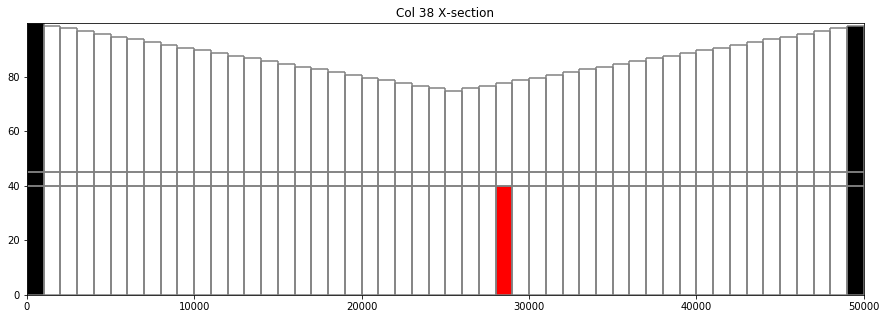

In [18]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'column': 37}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='black', color_ch='blue')
patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='gray')
t = ax.set_title('Col 38 X-section')

# 5. Read in the outputs

###  Heads and budget files

In [33]:
       #extract binary data from head file for scenario 1 (steady state)
# times = [0] #extract times at end of each stress period
# head = {} #create dictionary to store head data at end of each stress period
# frf = {} #create dictionary to store flows through right cell face at end of each stress period
# fff = {} #create dictionary to store flows through front cell face at end of each stress period
# storage = {} #create dictionary to store storage at end of each stress period
# consthead = {} #create dictionary to store constant head boundary at end of each stress period
# leakage = {} #create dictionary to store leakage at end of each stress period

#get data from python objects
# head = headobj.get_data(totim=1.0) #append heads to head list for ea stress per
# frf = budgobj.get_data(text='FLOW RIGHT FACE',totim=1.0) #append right face flow to frf list for ea stress per
# fff = budgobj.get_data(text='FLOW FRONT FACE',totim=1.0) #append front face flow to fff list for ea stress per
# #storage = budgobj.get_data(text='STORAGE',totim=1.0) #append front face flow to fff list for ea stress per
# consthead = budgobj.get_data(text='CONSTANT HEAD',totim=1.0) #append front face flow to fff list for ea stress per
# leakage = budgobj.get_data(text='RIVER LEAKAGE',totim=1.0) #append front face flow to fff list for ea stress per

#print(leakage)

# with open('heads.csv', 'w', newline='') as csvfile:  #creates an empty csv file called FP_heads
#     writer = csv.writer(csvfile, delimiter=',')        
#     for i in range(len(head[0,:,0])):                    #writes each row
#         writer.writerow(head[0,i,:])
 
    # Transient run - scenario 2

modelname = "scena3"
hds = bf.HeadFile(modelname+'.hds')                   # reads the binary head file
times = hds.get_times()    #returns a list of timesteps  
#times2 = [perlen[0],perlen[0]+perlen[1],perlen[0]+perlen[1]+perlen[2]] 
#print(times2)

  # extract binary data from head file
head = {} #create dictionary to store head data at end of each stress period
frf = {} #create dictionary to store flows through right cell face at end of each stress period
fff = {} #create dictionary to store flows through front cell face at end of each stress period
leakage = {} #create dictionary to store leakage at end of each stress period

headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds') #get head data as python object
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc') #get flow data as python object
leakage = budgobj.get_data(text='RIVER LEAKAGE',totim=1.0) #append front face flow to fff list for ea stress per

   


#get data from python objects
for stress_per, time in enumerate(times): #iterate through times at end of each stress period
    head['sp%s'%(stress_per)] = headobj.get_data(totim=time) #append heads to head list for ea stress per
    frf['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW RIGHT FACE',totim=time) #append right face flow to frf list for ea stress per
    fff['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time) #append front face flow to fff list for ea stress per
    

    # Head - 3 layer case
#headobj = bf.HeadFile(modelname1+'.hds')    #reads the binary head file
#times = headobj.get_times()                #returns a list of timesteps
#head = headobj.get_data(totim=times[-1])        #returns a numpy array of heads for specified time (last timestep)


    # Water balance - 3 layer case
#budgobj = bf.CellBudgetFile(modelname1+'.cbc')   #reads the cell budget file    
#print(budgobj.get_unique_record_names())
#kstpkper_list = budgobj.get_kstpkper()          #returns a list of stress periods & timesteps
#frf = budgobj.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
#fff = budgobj.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
#recharge = budgobj.get_data(text='RECHARGE', totim=1.0) 
#print(len(frf))


In [32]:
#
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc')
leakage = budgobj.get_data(text='RIVER LEAKAGE',totim=1.0)
#print(leakage[0])

leakage = {} #create dictionary to store leakage at end of each stress period
for stress_per, time in enumerate(times): #iterate through times at end of each stress period
    leakage['sp%s'%(stress_per)]=budgobj.get_data(text='RIVER LEAKAGE',totim=1.0) #append front face flow to fff list for ea stress per

    
flux = np.array(range(1,nper,5))

for i in range(1,nper,5): 
    perflux = 0
    for k in range(len(leakage[0])):
        #print(leakage['sp%s'%i][0][k][1])
        #perflux = perflux + leakage['sp%s'%i][0][k][1]
        flux[i] = flux[i] + leakage[0][k][1]
    #print(perflux)
print(flux)    

KeyError: 0

## 6. Plot head transect

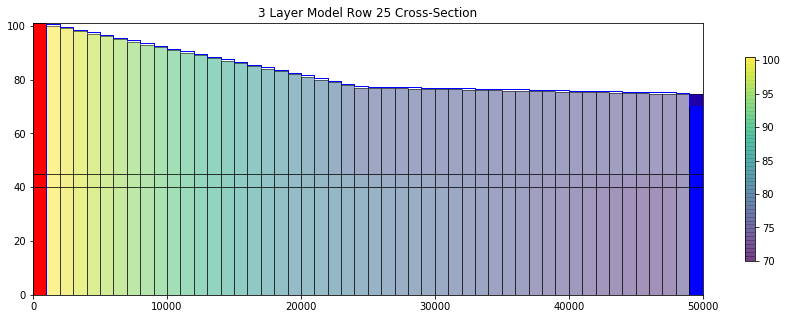

In [30]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect.plot_grid(color='green')
# t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')

pc = xsect.plot_array(head['sp0'], masked_values=[-999.99], head=head, alpha=0.5)
patches = xsect.plot_ibound(head=head['sp0'])
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model Row 25 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head['sp0'][0,:,:], masked_values=[999.], color='blue', lw=1)

### Plot : head in wells 

In [30]:


#plot a time series at both monitoring wells
#get time series for a certain cell
#print(well_loc)

cell_id1 = (0,25.0,25.0) #cell ID of MW1
cell_id2 = (0,36.0,11.0) #cell ID of MW2
irrg_id = (0,37.0, 13.0)#cell ID of ag well
town_wel_id = (2, 28.0, 37.0) #Cell ID of aguaseca community well
time_series1 = headobj.get_ts(cell_id1) #get the time series at MW1 using flopy
time_series2 = headobj.get_ts(cell_id2) #get the time series at MW2
time_series_irrg = headobj.get_ts(irrg_id) #get the time series at ag well
time_series_town_wel = headobj.get_ts(town_wel_id) #get the time series at aguaseca com well

#len(time_series1)
yearly_time_series1 = []
yearly_time_series1_head = []
#counter = 0
for i in range(0,901,36): ## transient solution is at 5 day inteval. i.e 25 yrs x 36 = 900 records
    temp = time_series1[i]   # for transient records collected every 1 day. range(0, 9001, 360)
    yearly_time_series1.append(temp[0])
    yearly_time_series1_head.append(temp[1])
    #yearly_time_series1.append(time_series1[i])
#print(time_series1)

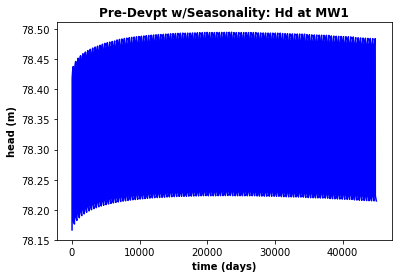

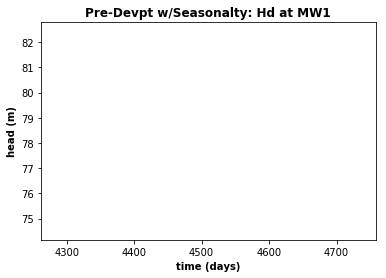

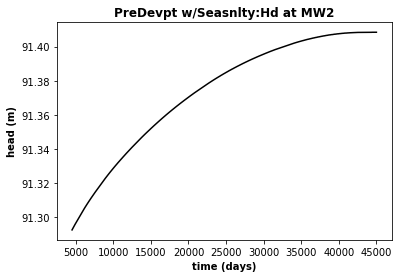

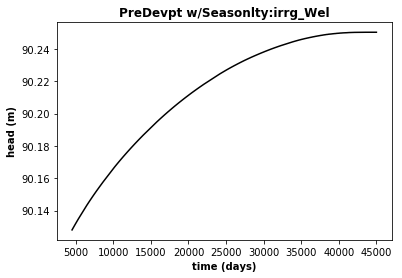

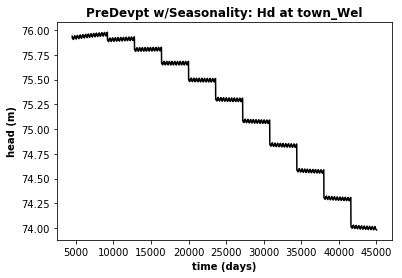

In [31]:
# MW1
plt.subplot(1, 1, 1)
plt.title("Pre-Devpt w/Seasonality: Hd at MW1",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series1[:, 0], time_series1[:, 1], 'b-') #plot the time series with points at each record
plt.show()

# MW1              end of year for 1st 25 yrs where Q = 0.
plt.subplot(1, 1, 1)
plt.title("Pre-Devpt w/Seasonalty: Hd at MW1",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(yearly_time_series1[25:], yearly_time_series1_head[25:], 'b-') #plot the time series with points at each record
plt.show()

# MW2 ## transient solution is obtained every 5 days. for 25 yrs x 36 = 900 records
plt.subplot(1, 1, 1)
plt.title("PreDevpt w/Seasnlty:Hd at MW2",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series2[900:, 0], time_series2[900:, 1], 'k-') #plot the time series with points at each record
plt.show()      

# irrg well
plt.subplot(1, 1, 1)
plt.title("PreDevpt w/Seasonlty:irrg_Wel",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series_irrg[900:, 0], time_series_irrg[900:, 1], 'k-') #plot the time series with points at each record
plt.show()

#create plot of town well
plt.subplot(1, 1, 1)
plt.title("PreDevpt w/Seasonality: Hd at town_Wel",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series_town_wel[900:, 0], time_series_town_wel[900:, 1], 'k-') #plot the time series with points at each record
plt.show()

In [25]:
#len(time_series1)
yearly_time_series1 = []

for i in range(0,901,36):  # yrl time series for 1st 25 yrs (900 days). ea stress per = 36 days
    temp = time_series1[i]
    temp2 = temp[1]
    #yearly_time_series1.append(temp[1])
    yearly_time_series1.append(time_series1[i])

print(yearly_time_series1)

[array([10.     , 78.16689], dtype=float32), array([190.     ,  78.43735], dtype=float32), array([370.     ,  78.17666], dtype=float32), array([550.     ,  78.44572], dtype=float32), array([730.    ,  78.1827], dtype=float32), array([910.     ,  78.45109], dtype=float32), array([1090.     ,   78.18706], dtype=float32), array([1270.     ,   78.45519], dtype=float32), array([1450.     ,   78.19052], dtype=float32), array([1630.     ,   78.45852], dtype=float32), array([1810.      ,   78.193535], dtype=float32), array([1990.      ,   78.461334], dtype=float32), array([2170.     ,   78.19612], dtype=float32), array([2350.     ,   78.46375], dtype=float32), array([2530.     ,   78.19838], dtype=float32), array([2710.     ,   78.46589], dtype=float32), array([2890.     ,   78.20037], dtype=float32), array([3070.      ,   78.467896], dtype=float32), array([3250.     ,   78.20214], dtype=float32), array([3430.      ,   78.469604], dtype=float32), array([3610.      ,   78.203735], dtype=float32

In [ ]:
print(yearly_time_series1)
#print(temp[1])
#type(temmp)
#type(temp2)
#print(counter)    



### head transect 

In [ ]:
# fig4 = plt.figure() 
# ax = fig4.add_subplot(1, 1, 1)

# x=np.arange(0,50000,1000) 
# plt.plot(x,head[2,int(well_1_row),:],marker='o', color='green', markersize=4, linestyle='--', label="bottom layer")
# plt.plot(x,head[0,int(well_1_row),:],marker='o', color='blue', markersize=4, linestyle='--', label="top layer")
# plt.title('Head transect')
# plt.xlabel('X location')
# plt.ylabel('Head')
# plt.legend()
# plt.savefig('Head_Transect.png')

